In [1]:
#Original code contributions by Dipanjan Sarkar
#https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html

#Merge layer is deprecated. Dot directly on embedding code from the following site
#https://stackoverflow.com/questions/52542275/merging-layers-on-keras-dot-product

#Contribution from Mukesh: (i) Preprocessing of Alice Corpus before training the Neural Network Model
#                          (ii) Loss Vs Epoch plots

#Skip gram Model
#It tries to predict the source context words (surrounding words) given a target word (the center word).
#Obtain word embeddings and explore similarity of words

#Build the corpus vocabulary
#Build a skip-gram [(target, context), relevancy] generator
#Build the skip-gram model architecture
#Train the Model
#Evaluate the model
#Check context relevancy
#Visualise word embedding

In [2]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import dot
from tensorflow.keras.models import Sequential
%pprint off

Pretty printing has been turned OFF


In [3]:
#Laurence Sterne, “The Life and Opinions of Tristram Shandy.” 107 words.
corpus = ["The French are certainly misunderstood:- but whether the fault is theirs, in not sufficiently explaining themselves, or speaking with that exact limitation and precision which one would expect on a point of such importance, and which, moreover, is so likely to be contested by us — or whether the fault may not be altogether on our side, in not understanding their language always so critically as to know “what they would be at” — I shall not decide; but ‘tis evident to me, when they affirm, “That they who have seen Paris, have seen every thing,” they must mean to speak of those who have seen it by day-light."]

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpus)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in corpus]

print('Vocabulary Size:', vocab_size) #80
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 80
Vocabulary Sample: [('not', 1), ('to', 2), ('they', 3), ('the', 4), ('be', 5), ('have', 6), ('seen', 7), ('but', 8), ('whether', 9), ('fault', 10)]


In [4]:
#Dictionary of the corpus from word to index
print(word2id)

{'not': 1, 'to': 2, 'they': 3, 'the': 4, 'be': 5, 'have': 6, 'seen': 7, 'but': 8, 'whether': 9, 'fault': 10, 'is': 11, 'in': 12, 'or': 13, 'and': 14, 'which': 15, 'would': 16, 'on': 17, 'of': 18, 'so': 19, 'by': 20, '—': 21, 'who': 22, 'french': 23, 'are': 24, 'certainly': 25, 'misunderstood': 26, 'theirs': 27, 'sufficiently': 28, 'explaining': 29, 'themselves': 30, 'speaking': 31, 'with': 32, 'that': 33, 'exact': 34, 'limitation': 35, 'precision': 36, 'one': 37, 'expect': 38, 'a': 39, 'point': 40, 'such': 41, 'importance': 42, 'moreover': 43, 'likely': 44, 'contested': 45, 'us': 46, 'may': 47, 'altogether': 48, 'our': 49, 'side': 50, 'understanding': 51, 'their': 52, 'language': 53, 'always': 54, 'critically': 55, 'as': 56, 'know': 57, '“what': 58, 'at”': 59, 'i': 60, 'shall': 61, 'decide': 62, '‘tis': 63, 'evident': 64, 'me': 65, 'when': 66, 'affirm': 67, '“that': 68, 'paris': 69, 'every': 70, 'thing': 71, '”': 72, 'must': 73, 'mean': 74, 'speak': 75, 'those': 76, 'it': 77, 'day': 78

In [5]:
#Reverse dictionary of the corpus from index to word
print(id2word)

{1: 'not', 2: 'to', 3: 'they', 4: 'the', 5: 'be', 6: 'have', 7: 'seen', 8: 'but', 9: 'whether', 10: 'fault', 11: 'is', 12: 'in', 13: 'or', 14: 'and', 15: 'which', 16: 'would', 17: 'on', 18: 'of', 19: 'so', 20: 'by', 21: '—', 22: 'who', 23: 'french', 24: 'are', 25: 'certainly', 26: 'misunderstood', 27: 'theirs', 28: 'sufficiently', 29: 'explaining', 30: 'themselves', 31: 'speaking', 32: 'with', 33: 'that', 34: 'exact', 35: 'limitation', 36: 'precision', 37: 'one', 38: 'expect', 39: 'a', 40: 'point', 41: 'such', 42: 'importance', 43: 'moreover', 44: 'likely', 45: 'contested', 46: 'us', 47: 'may', 48: 'altogether', 49: 'our', 50: 'side', 51: 'understanding', 52: 'their', 53: 'language', 54: 'always', 55: 'critically', 56: 'as', 57: 'know', 58: '“what', 59: 'at”', 60: 'i', 61: 'shall', 62: 'decide', 63: '‘tis', 64: 'evident', 65: 'me', 66: 'when', 67: 'affirm', 68: '“that', 69: 'paris', 70: 'every', 71: 'thing', 72: '”', 73: 'must', 74: 'mean', 75: 'speak', 76: 'those', 77: 'it', 78: 'day'

In [6]:
#Build a skip-gram [(target, context), relevancy] generator

#The function skipgrams(…) is present in keras.preprocessing.sequence
#skip-gram model - pairs of (X, Y) where X is input and Y is label.

#[(target, context), 1] pairs as positive input samples 
#where target is word of interest and context is a context word occurring near the target word 
#and the positive label 1 indicates this is a contextually relevant pair.

#[(target, random), 0] pairs as negative input samples where target is word of interest 
#but random is just a randomly selected word from vocabulary which has no context or association with target word.
#Hence the negative label 0. Indicates this is a contextually irrelevant pair.

# generate skip-grams with window_size of 5 by choosing window_size - 10
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

print("Length of skip_grams: ", len(skip_grams)) #1

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]

print("Number of skip_grams labels generated: ", len(labels), "\n") #4220 labels

#Number of labels 

#This function transforms a sequence of word indexes (list of integers) into tuples of words of the form:
#- (word, word in the same window), with label 1 (positive samples - contextually relevant pair).
#- (word, random word from the vocabulary), with label 0 (negative samples - contextually irrelevant pair).

#Generate 10 bigrams and show them(word (index)) with their relevancy (0/1)
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

Length of skip_grams:  1
Number of skip_grams labels generated:  4220 

(that (33), one (37)) -> 1
(every (70), have (6)) -> 1
(whether (9), language (53)) -> 0
(expect (38), speak (75)) -> 0
(they (3), decide (62)) -> 1
(limitation (35), fault (10)) -> 0
(themselves (30), mean (74)) -> 0
(misunderstood (26), the (4)) -> 1
(and (14), seen (7)) -> 0
(importance (42), know (57)) -> 0


In [7]:
#Build Neural Network Model for Skipgrams 

#For target and context
input_target = Input((1,), name='word')
input_context = Input((1,), name = 'context')

#For embedding into 100 dimensions
embedding = Embedding(vocab_size, embed_size, input_length=1)

#Once the target word is embedded, reshape 
word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)

#Once the context word is embedded, reshape 
context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

#Model class groups layers into an object with training and inference features.
model = Model(inputs=[input_target, input_context], outputs=output)

In [8]:
#Compile the model based on rmsprop optimizer and loss to be considered is MSE
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary()) #(Vocab(80) * Embedding Dimensions (100) = 8000 + dense layer (2)). Total parameters 8002

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
context (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       8000        word[0][0]                       
                                                                 context[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 1)       0           embedding[0][0]       

In [9]:
#Training the model for 100 epochs. Takes few seconds to train
#4220 skipgrams generated on a vocabulary of 80 words. 
#All the 4220 skipgrams with 4220 context relevancy labels will be trained for 100 epochs 

import numpy as np
Loss = []
Epoch = []
for epoch in range(1, 100):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    Loss.append(loss)
    Epoch.append(epoch)

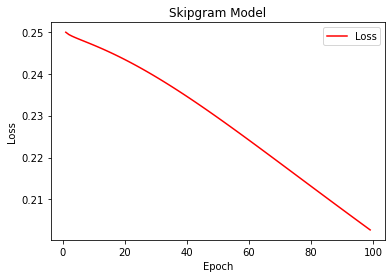

In [10]:
#Plot loss vs epoch
epLoL = list(zip(Epoch, Loss)) #Zip the list
epLoDF = pd.DataFrame(epLoL, columns = ['Epoch','Loss']) #Convert to a dataframe

epLoDF.plot.line(x='Epoch', y= 'Loss', c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Skipgram Model')
plt.show()

#Loss is decreasing after 100 epochs of training

In [11]:
#Try the Skipgram model with slightly larger corpus
#Download Alice in Wonderland from Project Gutenberg and store it in current working directory as Alice.txt

In [12]:
#Open the file
f = open('Alice.txt','r', encoding = 'utf-8')

#Read line by line
alice = f.readlines()

#Remove all \n elements 
alRem = list(map(lambda s: s.strip(), alice ))

#Check total number of elements
print("Total number of list elements: ", len(alRem)) #3773 elements

#List comprehension to remove empty strings
alNoEmpStr = [i for i in alRem if i]

#After removing empty strings, length of the list
print("Total length of list after removing empty strings: ", len(alNoEmpStr)) #2815 elements

#First sentence in Chapter One is 34th element and the last sentence is 2508th element
#prepare a corpus based on these element numbers
alCorpus = alNoEmpStr[34:2508]

print("First two elements: ", alCorpus[0:2]) #First two elements in the list
print("Last two elements: ", alCorpus[-2:]) #Last two elements in the list

Total number of list elements:  3773
Total length of list after removing empty strings:  2815
First two elements:  ['Alice was beginning to get very tired of sitting by her sister on the', 'bank, and of having nothing to do: once or twice she had peeped into']
Last two elements:  ['their simple joys, remembering her own child-life, and the happy summer', 'days.']


In [13]:
#Now corpus is ready for Skip-gram Modeling
tokenizer = text.Tokenizer() #Tokenizer instance

#Fit the tokenizer object on the Alice corpus
tokenizer.fit_on_texts(alCorpus)

#create a dictionary
word2idAl = tokenizer.word_index

#Build corpus vocabulary

#The PAD term is to pad context words to a fixed length if needed.
word2idAl['PAD'] = 0

#Exchange key and values and store in id2word for reverse mapping
id2wordAl = {v:k for k, v in word2idAl.items()}

#Each word is mapped to a number and stored as a list of list
widsAl = [[word2idAl[w] for w in text.text_to_word_sequence(doc)] for doc in alCorpus]
#print(wids)

#Size of the vocabulary
vocab_size_alice = len(word2idAl)

#Embedding dimension 
embed_size = 100

#context window size
window_size = 10 

print('Vocabulary Size:', vocab_size_alice) #3054
print('Vocabulary Sample:', list(word2idAl.items())[:25])

Vocabulary Size: 3055
Vocabulary Sample: [('the', 1), ('”', 2), ('and', 3), ('to', 4), ('a', 5), ('she', 6), ('of', 7), ('it', 8), ('said', 9), ('alice', 10), ('in', 11), ('was', 12), ('you', 13), ('i', 14), ('that', 15), ('as', 16), ('her', 17), ('at', 18), ('on', 19), ('with', 20), ('had', 21), ('all', 22), ('be', 23), ('for', 24), ('so', 25)]


In [14]:
# generate skip-grams with window_size of 5
skip_grams_alice = [skipgrams(wid, vocabulary_size=vocab_size_alice, window_size=10) for wid in widsAl]

print("Length of skip_grams_alice: ", len(skip_grams_alice)) #2474

# view sample skip-grams from first element
pairs_alice, labels_alice = skip_grams_alice[0][0], skip_grams_alice[0][1]
print("Number of labels in first element: ", len(labels_alice)) #340

pairs_last_alice, labels_last_alice = skip_grams_alice[-2][0], skip_grams_alice[-2][1]
print("Number of labels in last element: ", len(labels_last_alice)) #260

#Number of skipgrams generated are different as number of words in 2815 elements of list are different

#- (word, word in the same window), with label 1 (positive samples - contextually relevant pair).
#- (word, random word from the vocabulary), with label 0 (negative samples - contextually irrelevant pair).

for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2wordAl[pairs_alice[i][0]], pairs_alice[i][0], 
          id2wordAl[pairs_alice[i][1]], pairs_alice[i][1], 
          labels_alice[i]))

Length of skip_grams_alice:  2474
Number of labels in first element:  340
Number of labels in last element:  260
(beginning (287), her (17)) -> 1
(very (26), get (105)) -> 1
(was (12), very (26)) -> 1
(get (105), few (413)) -> 0
(beginning (287), tired (492)) -> 1
(to (4), was (12)) -> 1
(was (12), beginning (287)) -> 1
(of (7), to (4)) -> 1
(of (7), “pray (2607)) -> 0
(get (105), her (17)) -> 1


In [15]:
#Get all the skipgram pairs and labels generated in a single list 

pairsList = []
labelsList = []

for i in range(len(skip_grams_alice)):
    pairs, labels = skip_grams_alice[i][0], skip_grams_alice[i][1]
    pairsList.extend(pairs)
    labelsList.extend(labels)

print("Total skipgrams generated: ", len(pairsList))  #603232  
print("Total skipgrams context labels generated: ", len(labelsList)) ##603232

#List of list to hold pairs and labels
pairsLabels = [pairsList, labelsList]

#Confirm length of skipgramsList 
print("Length of first element of pairsLabels: ", len(np.array(list(zip(*pairsLabels[0]))[0], dtype='int32'))) #603232

#Confirm length of labels in pairsLabelsList
print("Length of labels: ", len(np.array(pairsLabels[1], dtype='int32'))) #603232  

Total skipgrams generated:  603232
Total skipgrams context labels generated:  603232
Length of first element of pairsLabels:  603232
Length of labels:  603232


In [16]:
#Build Skipgrams Neural Network Model for Alice Corpus 

#For target and context
input_target_a = Input((1,), name='aliceWord')
input_context_a = Input((1,), name = 'aliceContext')

#For embedding
embedding_a = Embedding(vocab_size_alice, embed_size, input_length=1, name='aliceEmbedding')

#Once the target word is embedded, reshape 
word_embedding_a = embedding_a(input_target_a)
word_embedding_a = Reshape((embed_size, 1))(word_embedding_a)

#Once the context word is embedded, reshape 
context_embedding_a = embedding_a(input_context_a)
context_embedding_a = Reshape((embed_size, 1))(context_embedding_a)

# now perform the dot product operation  
dot_product_a = dot([word_embedding_a, context_embedding_a], axes=1)
dot_product_a = Reshape((1,))(dot_product_a)

# add the sigmoid output layer
output_a = Dense(1, activation='sigmoid')(dot_product_a)

#Model class groups layers into an object with training and inference features.
model_alice = Model(inputs=[input_target_a, input_context_a], outputs=output_a)

In [17]:
#Compile the model
model_alice.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model_alice.summary()) #Vocab(3054) * Embedding Dimensions (300) = 916200 + dense layer (2). Total parameters 916202

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aliceWord (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
aliceContext (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
aliceEmbedding (Embedding)      (None, 1, 100)       305500      aliceWord[0][0]                  
                                                                 aliceContext[0][0]               
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 100, 1)       0           aliceEmbedding[0][0]  

In [18]:
#Train the model for 100 epochs. Takes less than five minutes to train
#603232 skipgrams generated from a vocabulary of 3054. 
#All the 603232 skipgrams with 603232 context relevancy labels will be trained for 100 epochs 

import numpy as np
LossAl = []
EpochAl = []
for epoch in range(1, 100):
    loss = 0
    pair_first_elem = np.array(list(zip(*pairsLabels[0]))[0], dtype='int32')
    pair_second_elem = np.array(list(zip(*pairsLabels[0]))[1], dtype='int32')
    labels = np.array(pairsLabels[1], dtype='int32')
    X = [pair_first_elem, pair_second_elem]
    Y = labels
    loss += model_alice.train_on_batch(X,Y)
    LossAl.append(loss)
    EpochAl.append(epoch)

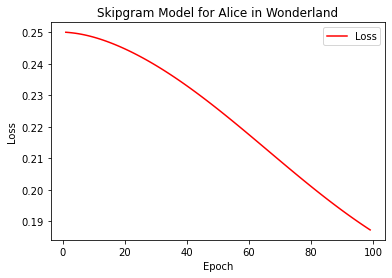

In [19]:
#Plot loss vs epoch
epLoAlL = list(zip(EpochAl, LossAl)) #Zip the list
epLoAlDF = pd.DataFrame(epLoAlL, columns = ['Epoch','Loss']) #Convert to a dataframe

epLoAlDF.plot.line(x='Epoch', y= 'Loss', c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Skipgram Model for Alice in Wonderland')
plt.show()

#Loss decreases steadily 

In [30]:
#Check for context relevancy by computing euclidean distance between weights


from sklearn.metrics.pairwise import euclidean_distances

weights_alice = model_alice.get_weights()[0]
weights_alice = weights_alice[1:]
distance_matrix_alice = euclidean_distances(weights_alice)
print(distance_matrix_alice.shape)

similar_words_alice = {search_term: [id2wordAl[idx] for idx in distance_matrix_alice[word2idAl[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['desk','soldiers','gryphon','hatter','cheshire','latitude', 'caterpillar','evidence','whiskers','alice' ]}

similar_words_alice

(3054, 3054)


{'desk': ['conduct', 'cold', 'hate—c', 'bough', 'softly'],
 'soldiers': ['else', 'tree', 'repeated', 'eagerly', 'shouted'],
 'gryphon': ['should', 'large', 'eyes', 'like', 'they'],
 'hatter': ['hare', 'shall', 'mock', 'was', 'who'],
 'cheshire': ['trial', 'eye', 'most', 'play', 'feel'],
 'latitude': ['longitude', 'anger', 'underneath', 'directed', 'appear'],
 'caterpillar': ['garden', 'house', 'till', 'indeed', 'behind'],
 'evidence': ['yourself', 'pepper', '“when', 'give', 'nervous'],
 'whiskers': ['messages', 'impossible', 'kick', 'flower', 'showing'],
 'alice': ['ever', 'if', '“and', 'at', 'so']}

In [25]:
#This model produces context relevant text as options for each of the words. 
#Results are better compared to CBOW model.

Total words: 60 	Word Embedding shapes: (60, 100)


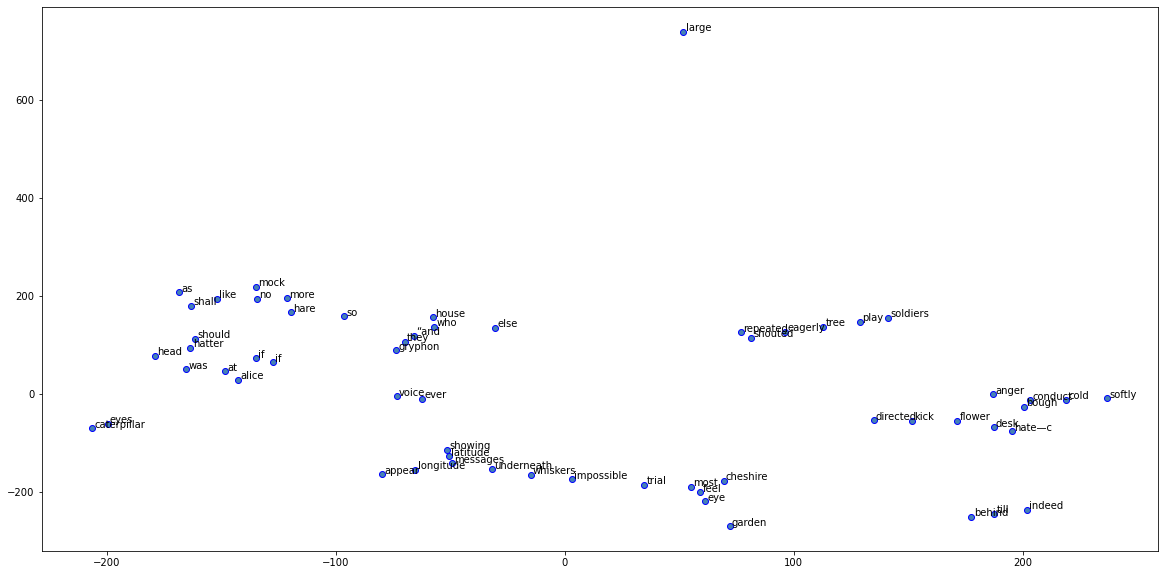

In [28]:
#TSNE - t distributed stochastic neighbourhood embedding
#Visualise the embeddings

from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words_alice.items()], [])
words_ids = [word2idAl[w] for w in words]
word_vectors = np.array([weights_alice[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

#Change perplexity values from 1 to 5
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(20, 10))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
#Different words of contextual similarity are positioned near each other

#Say  latitude and longitude 

#Change model perplexity values from 1 to 5 and observe different visualisations

##################################################################################################
##IT IS DIFFICULT TO REPRODUCE THE SAME RESULT FOR THE FOLLOWING REASONS:
    #SKIPGRAMS ARE GENERATED RANDOMLY (ONLY THE NUMBER OF SKIPGRAMS GENERATED IS FIXED)
    #TRAINING THE MODEL FOR MORE OR LESS EPOCHS WILL CHANGE THE RESULT
##################################################################################################